In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

# https://www.aeon-toolkit.org/en/stable/examples/datasets/load_data_from_web.html
import os
from aeon.datasets import load_classification
from ksfdtw.utils import nearest_neighbor_interpolation

In [2]:
def segment_concatenate(ts, seg_lengths):
    """
    Concatenate a time series ts according to seg_lengths.
    Each segment is shrunk to the specified length using nearest-neighbor interpolation.
    """
    P = len(seg_lengths)
    segments = []
    cutting_points = []
    start = 0
    for p in range(P):
        if seg_lengths[p] <= 0:
            raise ValueError("Segment length must be positive.")
        seg_rescaled = nearest_neighbor_interpolation(ts, seg_lengths[p])
        end = start + seg_lengths[p]
        segments.append(seg_rescaled)
        cutting_points.append((start, end))
        start = end
    concatenated = np.concatenate(segments)
    return concatenated, cutting_points

In [3]:
def transform_dataset_uniform(X, P=3):
    """
    Apply segment_concatenate transformation to every time series in X.
    """
    L = len(X[0][0])  # The second index refers to the channel index. Univariate => 0
    seg_lengths = [L // P + (1 if i < L % P else 0) for i in range(P)]

    transformed_segs = []
    cutting_points_list = []
    for ts in X:
        seg, cutting_points = segment_concatenate(ts[0], seg_lengths)
        transformed_segs.append(seg)
        cutting_points_list.append(cutting_points)
    return np.array(transformed_segs), np.array(cutting_points_list)

In [4]:
def generate_random_segment_lengths(L, P, l_min, l_max):
    """
    Generate random segment lengths that sum to L.
    Each segment length is between l_min and l_max.
    """
    if P * l_min > L or P * l_max < L:
        raise ValueError("Cannot generate segment lengths with given constraints.")

    while True:
        seg_lengths = [random.randint(l_min, l_max) for _ in range(P)]
        total_length = sum(seg_lengths)
        if total_length == L:
            return seg_lengths
        # Adjust lengths to match L
        diff = L - total_length
        for i in range(P):
            if diff == 0:
                break
            if diff > 0 and seg_lengths[i] < l_max:
                seg_lengths[i] += 1
                diff -= 1
            elif diff < 0 and seg_lengths[i] > l_min:
                seg_lengths[i] -= 1
                diff += 1

In [5]:
def transform_dataset_random(X, P=3, l=1.5):
    """
    Apply segment_concatenate transformation with random segment lengths to every time series in X.
    """
    m = len(X[0][0])
    L_avg = m / P
    l_root = math.sqrt(l)
    L_min = max(1, int(L_avg / l_root))
    L_max = min(int(L_avg * l_root), m)

    transformed_segs = []
    cutting_points_list = []
    for ts in X:
        seg_lengths = generate_random_segment_lengths(len(ts[0]), P, L_min, L_max)
        seg, cutting_points = segment_concatenate(ts[0], seg_lengths)
        transformed_segs.append(seg)
        cutting_points_list.append(cutting_points)
    return np.array(transformed_segs), np.array(cutting_points_list)

In [6]:
# Datasets
# length <= 200: SyntheticControl, SonyAIBORobotSurface1, ECG200, CBF, GunPoint, Adiac
# length > 200: Coffee, DodgerLoopDay, Beef, FaceFour, Lightning7, ToeSegmentation2, OliveOil
# SonyAIBORobotSurface1
dataset_name = "PowerCons"
# https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.datasets.load_classification.html
X_train, y_train = load_classification(
    name=dataset_name, split="train", extract_path="../data/"
)
X_test, y_test = load_classification(
    name=dataset_name, split="test", extract_path="../data/"
)

In [7]:
P = 3  # number of segments
l = 1.5  # scaling factor

X_train_trans_uniform = transform_dataset_uniform(X_train, P)
X_test_trans_uniform = transform_dataset_uniform(X_test, P)

X_train_trans_random = transform_dataset_random(X_train, P, l=l)
X_test_trans_random = transform_dataset_random(X_test, P, l=l)

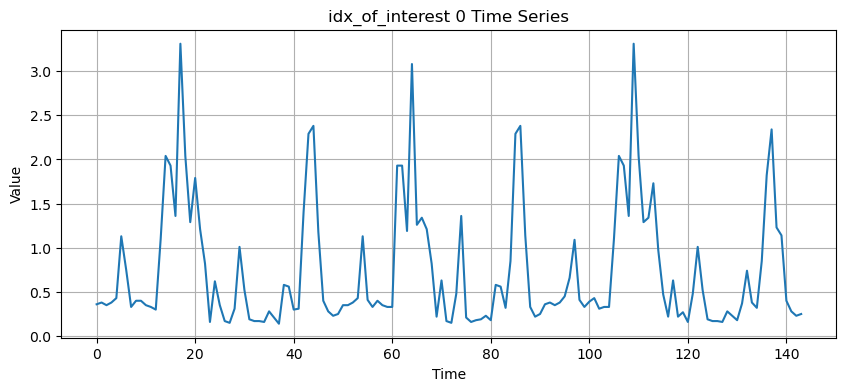

array([[  0,  50],
       [ 50,  91],
       [ 91, 144]])

In [8]:
# Look at the time series after transformation
idx_of_interest = 0  # Change this index to view different time series
plt.figure(figsize=(10, 4))
plt.plot(X_train_trans_random[0][idx_of_interest])
plt.title(f"idx_of_interest {idx_of_interest} Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()

X_train_trans_random[1][idx_of_interest]

In [9]:
save_dir = "../data_processed/"
file_name = f"{dataset_name}_P{P}_uniform.npz"
os.makedirs(save_dir, exist_ok=True)
np.savez_compressed(
    os.path.join(save_dir, file_name),
    X_train_trans_uniform_concatenated=X_train_trans_uniform[0],
    X_train_trans_uniform_cutting_points=X_train_trans_uniform[1],
    y_train=y_train,
    X_test_trans_uniform_concatenated=X_test_trans_uniform[0],
    X_test_cutting_points=X_test_trans_uniform[1],
    y_test=y_test,
)
print(f"Uniform dataset saved to {os.path.join(save_dir, file_name)}")

file_name = f"{dataset_name}_P{P}_l{l}_random.npz"
os.makedirs(save_dir, exist_ok=True)
np.savez_compressed(
    os.path.join(save_dir, file_name),
    X_train_trans_random_concatenated=X_train_trans_random[0],
    X_train_trans_random_cutting_points=X_train_trans_random[1],
    y_train=y_train,
    X_test_trans_random_concatenated=X_test_trans_random[0],
    X_test_trans_random_cutting_points=X_test_trans_random[1],
    y_test=y_test,
)
print(f"Random dataset saved to {os.path.join(save_dir, file_name)}")

Uniform dataset saved to ../data_processed/PowerCons_P3_uniform.npz
Random dataset saved to ../data_processed/PowerCons_P3_l1.5_random.npz


In [10]:
import datetime

print(f"This notebook was last run end-to-end on: {datetime.datetime.now()}\n")
###
###
###

This notebook was last run end-to-end on: 2025-11-13 17:07:21.881781

